In [120]:
from tqdm.notebook import tqdm

import torch
import numpy as np
from torchmetrics import MeanSquaredError, R2Score

from hpl.utils.postprocessing import (
    load_test_simulations,
    load_hydra_config,
    load_data_assimilation_network,
)
from hpl.datamodule import L96InferenceDataset

In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
plt.rc('image', cmap='gray')
plt.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)

In [154]:
device = torch.device("cuda")

test_data_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/testing/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
n_simulations = 5
noise_std = 1.0
mask_fraction = 0.75
ignore_edges = False

experiment_dir = "/gpfs/work/zinchenk/hpl_logs/data_assimilation/multirun/2023-08-16/17-34-47/11"

In [155]:
config = load_hydra_config(experiment_dir)
model = load_data_assimilation_network(experiment_dir, device)

In [156]:
simulations = load_test_simulations(test_data_dir, n_simulations)
dataset = L96InferenceDataset(
    ground_truth_data=simulations,
    input_window_extend=config.datamodule.dataset.input_window_extend,
    mask_fraction=mask_fraction,
    additional_noise_std=noise_std,
    drop_edge_samples=ignore_edges,
)
dataset.to(device)

In [157]:
reconstructions = []
with torch.no_grad():
    for sample in tqdm(dataset, total=len(dataset)):
        encoded_state = model.forward(sample).squeeze()
        reconstructions.append(encoded_state)
reconstructions = torch.stack(reconstructions, dim=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [158]:
sumulation_index = 0
if ignore_edges:
    input_window_extend = config.datamodule.dataset.input_window_extend
    ground_truth = dataset.ground_truth[sumulation_index, input_window_extend:-input_window_extend+1, :]
    observations = dataset.observations[sumulation_index, input_window_extend:-input_window_extend+1, :]
    mask = dataset.mask[sumulation_index, input_window_extend:-input_window_extend+1, :]
else:
    ground_truth = dataset.ground_truth[sumulation_index]
    observations = dataset.observations[sumulation_index]
    mask = dataset.mask[sumulation_index]
    
ground_truth = ground_truth.to(device)
observations = observations.to(device)
mask = mask.to(device)

In [159]:
rmse_func = MeanSquaredError(squared=False).to(device)
r2score_func = R2Score(num_outputs=reconstructions.size(-1)).to(device)

In [160]:
rmse = rmse_func(ground_truth, reconstructions[sumulation_index])
r2score = r2score_func(ground_truth, reconstructions[sumulation_index])
print(f"root-mean-squared-error: {round(rmse.item(), 2)}")
print(f"r2-score: {round(r2score.item(), 2)}")

root-mean-squared-error: 0.68
r2-score: 0.96


In [161]:
observations_plot = torch.masked_fill(observations, mask.bool(), np.nan)
vlim = torch.stack([ground_truth.abs(), observations.abs(), reconstructions[sumulation_index].abs()]).max().item()
difference = ground_truth - reconstructions[sumulation_index]
dlim = difference.abs().max()

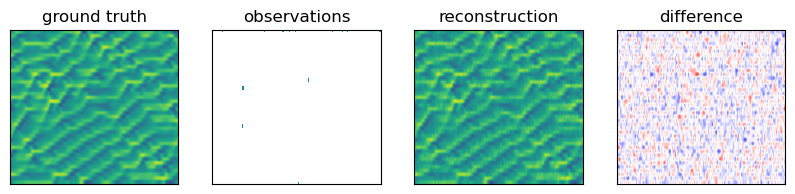

In [162]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
axes[0].imshow(ground_truth.cpu().T, aspect="auto", cmap="viridis", vmin=-vlim, vmax=vlim)
axes[1].imshow(observations_plot.cpu().T, aspect="auto", cmap="viridis", vmin=-vlim, vmax=vlim)
axes[2].imshow(reconstructions[sumulation_index].cpu().T, aspect="auto", cmap="viridis", vmin=-vlim, vmax=vlim)
axes[3].imshow(difference.cpu().T, aspect="auto", cmap="bwr", vmin=-dlim, vmax=dlim)

axes[0].set_title("ground truth")
axes[1].set_title("observations")
axes[2].set_title("reconstruction")
axes[3].set_title("difference")

for ax in axes:
    ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)